In [1]:
import torch, os
import torch.nn.functional as F
import lightning as pl
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import rearrange

from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision.datasets import MNIST

from modules.trainers.DDPM import DDPM

In [2]:
model = DDPM.load_from_checkpoint('/home/exouser/genmod/genmod/399e8se1/checkpoints/last.ckpt')
model.eval()

DDPM(
  (nn_model): ContextUnet(
    (init_conv): ResidualConvBlock(
      (conv1): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): GELU(approximate='none')
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): GELU(approximate='none')
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): ResidualConvBlock(
          (conv1): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (2): GELU(approximate='none')
          )
          (conv2): Sequential(
            (0): Conv2d(128, 128, k

100%|██████████| 499/499 [00:02<00:00, 208.49it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


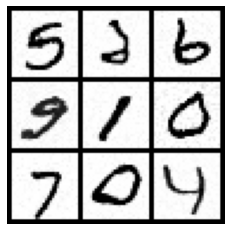

In [13]:
device = "cuda:0"

torch.cuda.empty_cache()

model = model.to(device)

gen_imgs = []
for _ in range(9):
    x_i = torch.randn((1,1,28,28)).to(device)  # x_T ~ N(0, 1), sample initial noise
    for i in tqdm(range(model.n_T-1, 0, -1)):
        t_is = torch.tensor([i / model.n_T]).to(device)
        t_is = t_is.repeat(x_i.size(0),1,1,1)

        z = torch.randn_like(x_i).to(device) if i > 1 else 0

        eps = model.nn_model(x_i, t_is)
        x_i = (
            model.oneover_sqrta[i] * (x_i - eps * model.mab_over_sqrtmab[i])
            + model.sqrt_beta_t[i] * z
        )

    gen_imgs.append(x_i.squeeze(0).detach().cpu())
    
gen_imgs = rearrange(gen_imgs, 'b c h w -> b c h w')
# create grid
grid = make_grid(gen_imgs*-1 + 1, nrow=3, padding=2)

# plot grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()